### Laplacian embedding

Material generously taken from scikit learn, [here](https://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#sphx-glr-auto-examples-manifold-plot-compare-methods-py).

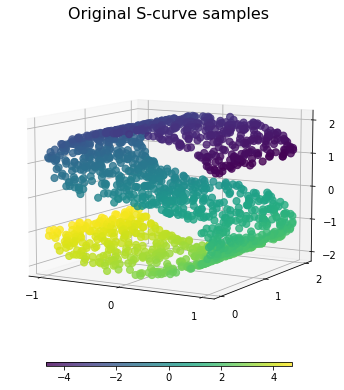

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker

from sklearn import datasets, manifold

n_samples = 1500
S_points, S_color = datasets.make_s_curve(n_samples, random_state=0)

# %%
# Let's look at the original data. Also define some helping
# functions, which we will use further on.


def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())


plot_3d(S_points, S_color, "Original S-curve samples")



### Construct Laplacian and embedding

In [2]:
from sklearn.neighbors import DistanceMetric
from scipy.linalg import eigh

def construct_L(X, sigma = 0.5):
    dist = DistanceMetric.get_metric('euclidean')
    R = dist.pairwise(X)
    W = np.exp(-(R/sigma)**2)


    d = np.sum(W,1)
    D = np.diag(d)
    L_uns = D - W

    return L_uns, D

def laplacian_embedding(L, D, nc):
    l, v = eigh(L, D)
    ind = np.argsort(l)
    l = l[ind]
    v = v[:,ind]

    # Pick the d smallest (nonzero) eigenvalues 
    Yh = v[:,1:1+nc]
    return Yh, l

### Compute eigenvectors for embedding

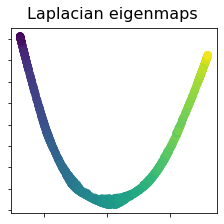

Text(0.5, 1.0, 'Eigenvalues')

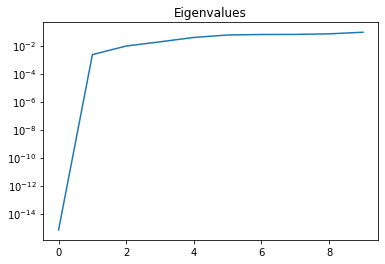

In [3]:
# Visualize the plots
L, D = construct_L(S_points, np.sqrt(0.1))
Yh, lh = laplacian_embedding(L, D, 2)
plot_2d(Yh, S_color, "Laplacian eigenmaps")
plt.semilogy(np.arange(10),lh[:10]); plt.title("Eigenvalues")

### PCA on same dataset

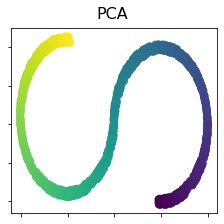

In [4]:
def mypca(S,nc):
    mu = np.mean(S,1)
    #Remove mean from the samples
    Ss = S - np.tile(mu[:,np.newaxis],(1,S.shape[1]))
    
    #Compute the SVD of the shifted matrix
    u,s,vh = np.linalg.svd(Ss, full_matrices = False)
    
    u = u[:,:nc]   #Principal directions
    s = s[:nc]     #Singular values that can be used to explain variance 
    
    y = u.T @ S
    return u, s, y

S = S_points.T
u, s, y_pca = mypca(S, 2)
plot_2d(y_pca.T, S_color, "PCA")

# Digits dataset

In [5]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib import offsetbox

def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

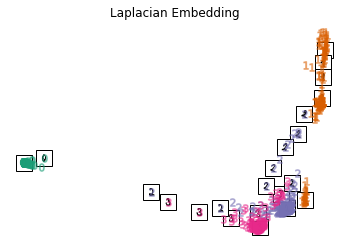

In [6]:
from sklearn.datasets import load_digits

digits = load_digits(n_class=4)
Xd, y = digits.data, digits.target

Ld, Dd = construct_L(Xd, sigma = 16.)
Yd, ld = laplacian_embedding(Ld, Dd, 2)
plot_embedding(Yd, 'Laplacian Embedding')

In [7]:
print(Xd.shape)

(720, 64)


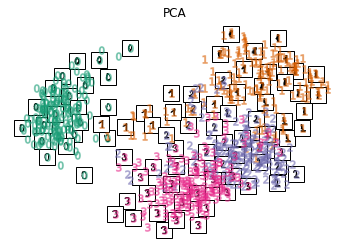

In [8]:
S = Xd.T
u, s, y_pca = mypca(S, 2)
plot_embedding(y_pca.T,  "PCA")

In [9]:
np.max(Xd)

16.0